<a href="https://colab.research.google.com/github/PriyanshuRao-code/AI-Lab-Project/blob/main/team_24_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [245]:
# Don't do anything here. It's just a setup.
import os
import sys

repo_name = "AI-Lab-Project"
repo_url = "https://github.com/PriyanshuRao-code/AI-Lab-Project.git"
repo_path = f"/content/{repo_name}"

if os.path.exists(repo_path):
    print("Repository already exists at:", repo_path)
else:
    print("🚀 Cloning the repository...")
    os.system(f"git clone {repo_url}")

os.chdir(repo_path)
sys.path.append(repo_path)

print("Repository is ready to use at:", repo_path)

Repository already exists at: /content/AI-Lab-Project
Repository is ready to use at: /content/AI-Lab-Project


In [246]:
# Using supporting files (now as .ipynb and later .py)

!pip install import-ipynb
import import_ipynb
from team_24_data_preprocessing import *
from team_24_supervised_learning import *

In [247]:
df = pd.read_csv('24.csv')
df_knn = pd.read_csv('24.csv')

In [248]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter

In [249]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [250]:
def x_y_separation(df_train, df_valid, df_test, target_column="Hazardous"):
  X_train = df_train.drop(columns=[target_column])
  y_train = df_train[target_column]

  X_valid = df_valid.drop(columns=[target_column])
  y_valid = df_valid[target_column]

  X_test = df_test.drop(columns=[target_column])
  y_test = df_test[target_column]

  return X_train, y_train, X_valid, y_valid, X_test, y_test

In [251]:
def remove_outliers_zscore(df_train, df_valid, df_test, z_score_threshold = 3):

  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_train_non_numeric = df_train.select_dtypes(exclude=['number'])

  z_scores = df_train_numeric.apply(zscore)
  df_z = df_train_numeric[(z_scores.abs() < z_score_threshold).all(axis=1)]  # Remove rows with Z-score >  z_score_threshold in any column
  df_train_cleaned = pd.concat([df_z, df_train_non_numeric.loc[df_z.index]], axis=1)

  return df_train_cleaned, df_valid, df_test

In [252]:
def label_encode_categorical(df_train, df_valid, df_test):

  categorical_cols = df_train.select_dtypes(include=['object']).columns
  label_encoders = {}

  for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df_train[col] = label_encoders[col].fit_transform(df_train[col])

    df_valid[col] = df_valid[col].map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)
    df_test[col] = df_test[col].map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)

  df_valid = df_valid[df_train.columns]
  df_test = df_test[df_train.columns]

  return df_train, df_valid, df_test

In [253]:
def standardize_data(df_train_orig, df_valid_orig, df_test_orig):
  df_train = df_train_orig.copy()
  df_valid = df_valid_orig.copy()
  df_test = df_test_orig.copy()
  scaler = StandardScaler()

  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_test_numeric = df_test.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_valid_numeric = df_valid.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])

  # Standardization
  df_train[df_train_numeric.columns] = scaler.fit_transform(df_train_numeric)
  df_test[df_test_numeric.columns] = scaler.transform(df_test_numeric)
  df_valid[df_valid_numeric.columns] = scaler.transform(df_valid_numeric)

  return df_train, df_valid, df_test

In [254]:
def remove_highly_correlated(df_train, df_valid, df_test, high_corr_threshold = 0.99):

  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])

  high_corr_pairs = set()
  correlation_matrix = df_train_numeric.corr()

  for i in range(len(correlation_matrix.columns)):
    for j in range(i): # Lower triangular matrix
      if abs(correlation_matrix.iloc[i, j]) >= high_corr_threshold:
        col1 = correlation_matrix.columns[i]
        col2 = correlation_matrix.columns[j]
        high_corr_pairs.add((col1, col2))

  columns_to_drop = {col2 for col1, col2 in high_corr_pairs}

  df_train_reduced = df_train.drop(columns=columns_to_drop)
  df_valid_reduced = df_valid.drop(columns=columns_to_drop)
  df_test_reduced = df_test.drop(columns=columns_to_drop)

  return df_train_reduced, df_valid_reduced, df_test_reduced

In [255]:
def perform_pca(df_train, df_valid, df_test, target_col="Hazardous", n_components=3):

  # Split features & target
  X_train = df_train.drop(columns=[target_col])
  X_valid = df_valid.drop(columns=[target_col])
  X_test  = df_test.drop(columns=[target_col])

  y_train = df_train[target_col].reset_index(drop=True)
  y_valid = df_valid[target_col].reset_index(drop=True)
  y_test  = df_test[target_col].reset_index(drop=True)

  # PCA
  pca = PCA(n_components=n_components)
  pca.fit(X_train)

  X_train_pca = pd.DataFrame(pca.transform(X_train), columns=[f'PC{i+1}' for i in range(n_components)])
  X_valid_pca = pd.DataFrame(pca.transform(X_valid), columns=[f'PC{i+1}' for i in range(n_components)])
  X_test_pca  = pd.DataFrame(pca.transform(X_test),  columns=[f'PC{i+1}' for i in range(n_components)])

  # Add target back
  df_train_pca = pd.concat([X_train_pca, y_train], axis=1)
  df_valid_pca = pd.concat([X_valid_pca, y_valid], axis=1)
  df_test_pca  = pd.concat([X_test_pca,  y_test],  axis=1)

  return df_train_pca, df_valid_pca, df_test_pca

In [256]:
class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)  # Output Layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [257]:
import random

def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [258]:
def train_model_perceptron(df_train, df_valid, df_test, target_column = "Hazardous", num_epochs=2000, lr=0.0001):

  # Each time it may have different accuracy, recall due to ->  Weight Initialization of Perceptron is Random
  X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)

  X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
  X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
  X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

  y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
  y_valid_tensor = torch.tensor(y_valid.values.reshape(-1, 1), dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)


  perceptron_model = Perceptron(X_train_tensor.shape[1])

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.SGD(perceptron_model.parameters(), lr=lr)

  for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = perceptron_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # if epoch % 10 == 0:
    #   print(f"Epoch {epoch}, Loss: {loss.item()}")

  with torch.no_grad():
    y_valid_pred_nn = perceptron_model(X_valid_tensor).sigmoid().round()
    y_test_pred_nn = perceptron_model(X_test_tensor).sigmoid().round()

    # Convert tensors to numpy
    y_valid_pred_nn = y_valid_pred_nn.detach().numpy()
    y_test_pred_nn = y_test_pred_nn.detach().numpy()

    # Convert y_valid, y_test to numpy for evaluation
    y_valid_numpy = y_valid_tensor.detach().numpy()
    y_test_numpy = y_test_tensor.detach().numpy()

  return perceptron_model, y_valid_numpy, y_test_numpy, y_valid_pred_nn, y_test_pred_nn

In [259]:
set_seeds(42)

In [260]:
# def train_model_random_forest(df_train, df_valid, df_test, target_column="Hazardous"):

#     X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)

#     X_train_rf = np.array(X_train)
#     X_valid_rf = np.array(X_valid)
#     X_test_rf = np.array(X_test)

#     y_train_rf = np.array(y_train)
#     y_valid_rf = np.array(y_valid)
#     y_test_rf = np.array(y_test)

#     random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
#     random_forest.fit(X_train_rf, y_train_rf)

#     y_valid_pred_rf = random_forest.predict(X_valid_rf)
#     y_test_pred_rf = random_forest.predict(X_test_rf)

#     return random_forest, y_valid_rf, y_test_rf, y_valid_pred_rf, y_test_pred_rf

In [261]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

def evaluate_model(y_true, y_pred, model_name="Model", return_metrics=False):
    print(f"\nEvaluation Metrics for {model_name}:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=["Not Hazardous", "Hazardous"], yticklabels=["Not Hazardous", "Hazardous"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n=== Evaluation Report for {model_name} ===")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    if return_metrics:
        return {
            'accuracy': accuracy,
            'recall': recall,
            'precision': precision,
            'f1_score': f1
        }

In [262]:
df_train_full, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Hazardous'])
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['Hazardous'])

In [263]:
df_train, df_valid, df_test = remove_outliers_zscore(df_train_full, df_valid, df_test)

In [264]:
df_train, df_valid, df_test = label_encode_categorical(df_train, df_valid, df_test)

In [265]:
df_train, df_valid, df_test = remove_highly_correlated(df_train, df_valid, df_test)

In [266]:
df_train, df_valid, df_test = standardize_data(df_train, df_valid, df_test)


===== Perceptron with PCA (n_components=1) =====

Evaluation Metrics for Perceptron with PCA-1:


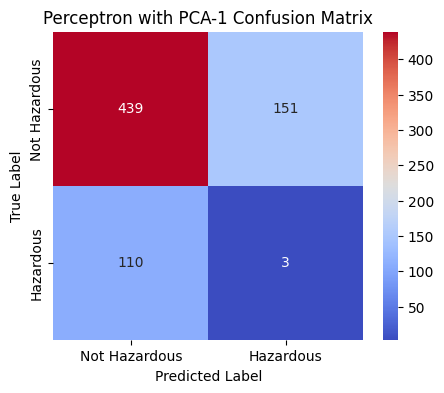


=== Evaluation Report for Perceptron with PCA-1 ===
Accuracy : 0.6287
Recall   : 0.0265
Precision: 0.0195
F1 Score : 0.0225

Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.74      0.77       590
         1.0       0.02      0.03      0.02       113

    accuracy                           0.63       703
   macro avg       0.41      0.39      0.40       703
weighted avg       0.67      0.63      0.65       703


===== Perceptron with PCA (n_components=2) =====

Evaluation Metrics for Perceptron with PCA-2:


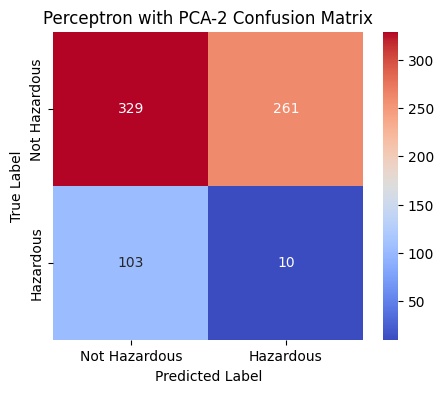


=== Evaluation Report for Perceptron with PCA-2 ===
Accuracy : 0.4822
Recall   : 0.0885
Precision: 0.0369
F1 Score : 0.0521

Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.56      0.64       590
         1.0       0.04      0.09      0.05       113

    accuracy                           0.48       703
   macro avg       0.40      0.32      0.35       703
weighted avg       0.65      0.48      0.55       703


===== Perceptron with PCA (n_components=3) =====

Evaluation Metrics for Perceptron with PCA-3:


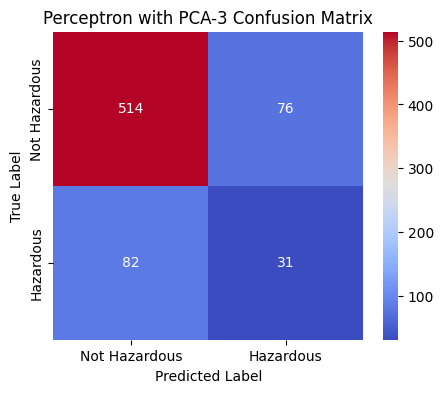


=== Evaluation Report for Perceptron with PCA-3 ===
Accuracy : 0.7752
Recall   : 0.2743
Precision: 0.2897
F1 Score : 0.2818

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       590
         1.0       0.29      0.27      0.28       113

    accuracy                           0.78       703
   macro avg       0.58      0.57      0.57       703
weighted avg       0.77      0.78      0.77       703


===== Perceptron with PCA (n_components=4) =====

Evaluation Metrics for Perceptron with PCA-4:


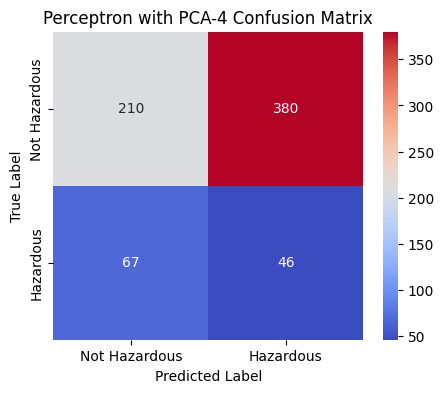


=== Evaluation Report for Perceptron with PCA-4 ===
Accuracy : 0.3642
Recall   : 0.4071
Precision: 0.1080
F1 Score : 0.1707

Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.36      0.48       590
         1.0       0.11      0.41      0.17       113

    accuracy                           0.36       703
   macro avg       0.43      0.38      0.33       703
weighted avg       0.65      0.36      0.43       703


===== Perceptron with PCA (n_components=5) =====

Evaluation Metrics for Perceptron with PCA-5:


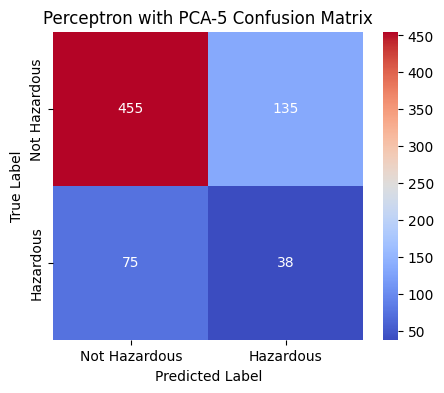


=== Evaluation Report for Perceptron with PCA-5 ===
Accuracy : 0.7013
Recall   : 0.3363
Precision: 0.2197
F1 Score : 0.2657

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.77      0.81       590
         1.0       0.22      0.34      0.27       113

    accuracy                           0.70       703
   macro avg       0.54      0.55      0.54       703
weighted avg       0.76      0.70      0.72       703


===== Perceptron with PCA (n_components=6) =====

Evaluation Metrics for Perceptron with PCA-6:


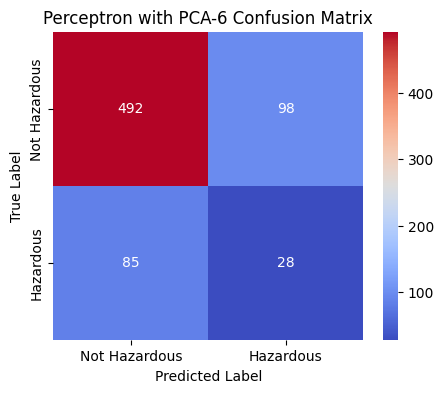


=== Evaluation Report for Perceptron with PCA-6 ===
Accuracy : 0.7397
Recall   : 0.2478
Precision: 0.2222
F1 Score : 0.2343

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.83      0.84       590
         1.0       0.22      0.25      0.23       113

    accuracy                           0.74       703
   macro avg       0.54      0.54      0.54       703
weighted avg       0.75      0.74      0.75       703


===== Perceptron with PCA (n_components=7) =====

Evaluation Metrics for Perceptron with PCA-7:


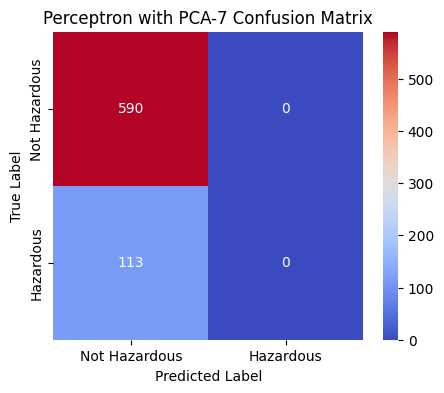


=== Evaluation Report for Perceptron with PCA-7 ===
Accuracy : 0.8393
Recall   : 0.0000
Precision: 0.0000
F1 Score : 0.0000

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      1.00      0.91       590
         1.0       0.00      0.00      0.00       113

    accuracy                           0.84       703
   macro avg       0.42      0.50      0.46       703
weighted avg       0.70      0.84      0.77       703


===== Perceptron with PCA (n_components=8) =====

Evaluation Metrics for Perceptron with PCA-8:


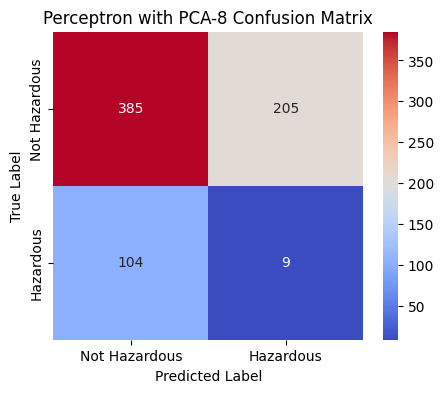


=== Evaluation Report for Perceptron with PCA-8 ===
Accuracy : 0.5605
Recall   : 0.0796
Precision: 0.0421
F1 Score : 0.0550

Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.65      0.71       590
         1.0       0.04      0.08      0.06       113

    accuracy                           0.56       703
   macro avg       0.41      0.37      0.38       703
weighted avg       0.67      0.56      0.61       703


===== Perceptron with PCA (n_components=9) =====

Evaluation Metrics for Perceptron with PCA-9:


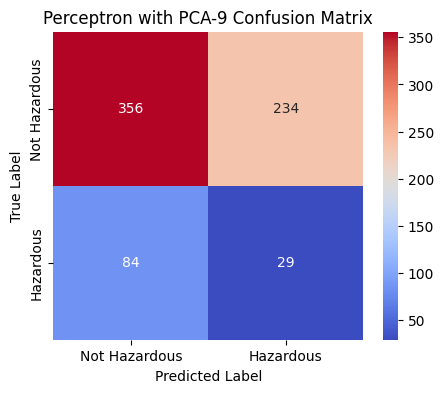


=== Evaluation Report for Perceptron with PCA-9 ===
Accuracy : 0.5477
Recall   : 0.2566
Precision: 0.1103
F1 Score : 0.1543

Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.60      0.69       590
         1.0       0.11      0.26      0.15       113

    accuracy                           0.55       703
   macro avg       0.46      0.43      0.42       703
weighted avg       0.70      0.55      0.60       703


===== Perceptron with PCA (n_components=10) =====

Evaluation Metrics for Perceptron with PCA-10:


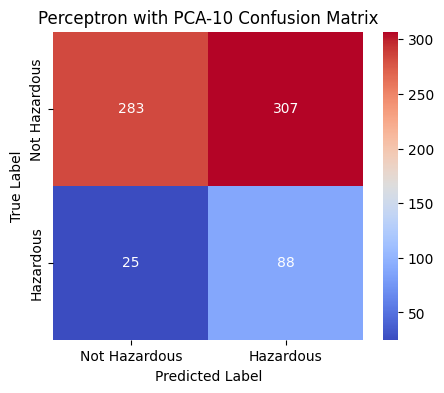


=== Evaluation Report for Perceptron with PCA-10 ===
Accuracy : 0.5277
Recall   : 0.7788
Precision: 0.2228
F1 Score : 0.3465

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.48      0.63       590
         1.0       0.22      0.78      0.35       113

    accuracy                           0.53       703
   macro avg       0.57      0.63      0.49       703
weighted avg       0.81      0.53      0.58       703


===== Perceptron with PCA (n_components=11) =====

Evaluation Metrics for Perceptron with PCA-11:


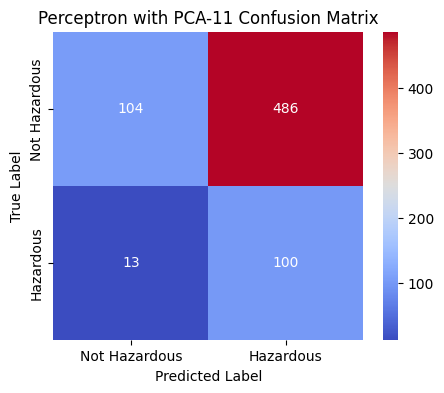


=== Evaluation Report for Perceptron with PCA-11 ===
Accuracy : 0.2902
Recall   : 0.8850
Precision: 0.1706
F1 Score : 0.2861

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.18      0.29       590
         1.0       0.17      0.88      0.29       113

    accuracy                           0.29       703
   macro avg       0.53      0.53      0.29       703
weighted avg       0.77      0.29      0.29       703



In [267]:
metrics_summary = []

for n_components in range(1, min(len(df_train.columns), 12)):  # prevent PCA n_components from exceeding feature count
    print(f"\n===== Perceptron with PCA (n_components={n_components}) =====")

    df_train_pca, df_valid_pca, df_test_pca = perform_pca(df_train, df_valid, df_test, n_components=n_components)
    model, y_valid_true, y_test_true, y_valid_pred, y_test_pred = train_model_perceptron(
        df_train_pca, df_valid_pca, df_test_pca
    )

    metrics = evaluate_model(y_valid_true, y_valid_pred, model_name=f"Perceptron with PCA-{n_components}", return_metrics=True)

    metrics_summary.append({
        'n_components': n_components,
        'accuracy': metrics['accuracy'],
        'recall': metrics['recall'],
        'precision': metrics['precision'],
        'f1_score': metrics['f1_score']
    })

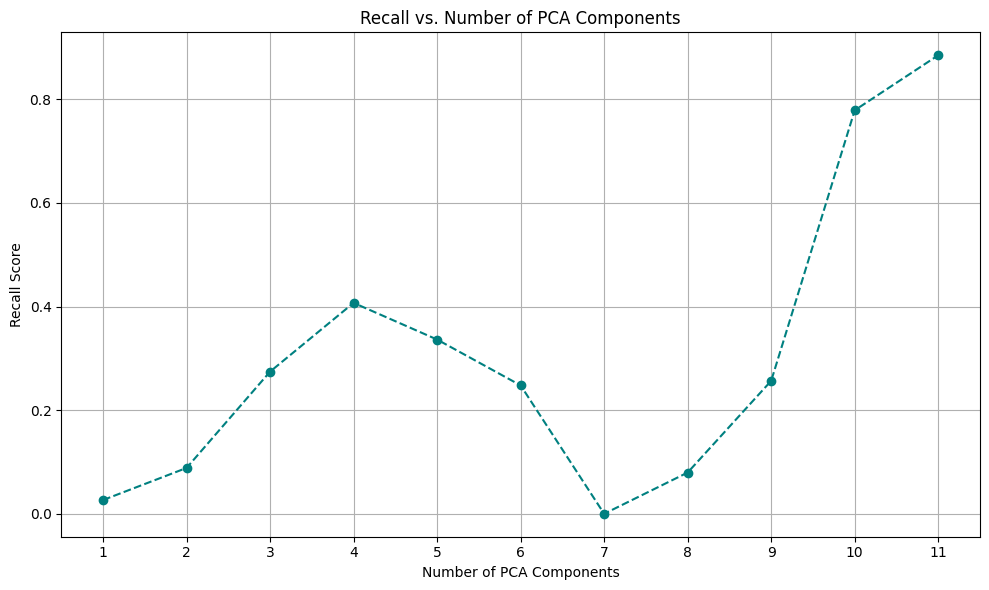

In [268]:
n_components = [entry['n_components'] for entry in metrics_summary]
recall_scores = [entry['recall'] for entry in metrics_summary]


plt.figure(figsize=(10, 6))
plt.plot(n_components, recall_scores, marker='o', linestyle='--', color='teal')
plt.title('Recall vs. Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Recall Score')
plt.grid(True)
plt.xticks(n_components)
plt.tight_layout()
plt.show()

In [269]:
metrics_df = pd.DataFrame(metrics_summary)

best_accuracy_pca = metrics_df.loc[metrics_df['accuracy'].idxmax(), 'n_components']
best_recall_pca = metrics_df.loc[metrics_df['recall'].idxmax(), 'n_components']
best_precision_pca = metrics_df.loc[metrics_df['precision'].idxmax(), 'n_components']
best_f1_pca = metrics_df.loc[metrics_df['f1_score'].idxmax(), 'n_components']

print("\n========= Best PCA Results =========")
print(f"Highest Accuracy: PCA Components = {best_accuracy_pca}")
print(f"Highest Recall: PCA Components = {best_recall_pca}")
print(f"Highest Precision: PCA Components = {best_precision_pca}")
print(f"Highest F1-Score: PCA Components = {best_f1_pca}")


========= Best PCA Results =========
Highest Accuracy: PCA Components = 7
Highest Recall: PCA Components = 11
Highest Precision: PCA Components = 3
Highest F1-Score: PCA Components = 10


In [215]:
# def find_best_seed_for_recall_with_accuracy_check(df_train, df_valid, df_test, target_col="Hazardous", n_components=23, seed_range=range(10), accuracy_threshold=0.4):
#     """
#     Finds the seed that gives the highest recall score while ensuring that accuracy is above the specified threshold.
#     Only tests a fixed PCA component count for speed (default = 3).
#     """
#     best_seed = None
#     best_recall = -1
#     seed_metrics = []

#     for seed in seed_range:
#         print(f"\nTrying seed {seed}...")
#         set_seeds(seed)

#         # Perform PCA and train model
#         df_train_pca, df_valid_pca, df_test_pca = perform_pca(df_train, df_valid, df_test, target_col, n_components)
#         model, y_valid_true, _, y_valid_pred, y_test_pred = train_model_perceptron(
#             df_train_pca, df_valid_pca, df_test_pca, target_column=target_col
#         )

#         # Calculate recall and accuracy
#         recall = recall_score(y_valid_true, y_valid_pred)
#         accuracy = accuracy_score(y_valid_true, y_valid_pred)

#         # Skip seeds where accuracy is below the threshold
#         if accuracy < accuracy_threshold:
#             print(f"Seed {seed} skipped due to low accuracy ({accuracy:.4f})")
#             continue

#         seed_metrics.append({
#             'seed': seed,
#             'accuracy': accuracy,
#             'recall': recall
#         })

#         # Update best recall if this seed has a higher recall
#         if recall > best_recall:
#             best_recall = recall
#             best_seed = seed

#     print("\n Best Seed Based on Recall with Accuracy >= 0.4:")
#     print(f"Seed: {best_seed} with Recall: {best_recall:.4f}")
#     return best_seed, pd.DataFrame(seed_metrics)


In [216]:
# This will test for seeds in the range 0 to 19, and only consider seeds with accuracy >= 0.4
# best_seed, recall_df = find_best_seed_for_recall_with_accuracy_check(df_train, df_valid, df_test, n_components=23, seed_range=ran/ge(0, 42), accuracy_threshold=0.4)

In [217]:
#Hyperparameter tuning in number of hidden layers for Multi-Layered Neural Networks
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(NeuralNet, self).__init__()
        layers = []
        prev_size = input_size
        for layer_size in hidden_layers:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(nn.Sigmoid())  # Can switch to ReLU later if needed
            prev_size = layer_size
        layers.append(nn.Linear(prev_size, 1))  # No sigmoid here!
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [218]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
import numpy as np

def evaluate_model_nn(y_true, y_pred, model_name="Model", return_metrics=False):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n=== Evaluation Report for {model_name} ===")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))

    if return_metrics:
        return {
            'accuracy': accuracy,
            'recall': recall,
            'precision': precision,
            'f1_score': f1,
            'confusion_matrix': cm
        }


In [219]:
def train_model_fcnn(df_train, df_valid, df_test, target_column="Hazardous",
                     num_epochs=2000, lr=0.0001,
                     hidden_layers_list=[[10], [17], [31], [64], [100]], seed=42):

    import torch
    import torch.nn as nn
    import torch.optim as optim
    import numpy as np
    import pandas as pd
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    import seaborn as sns
    import matplotlib.pyplot as plt

    set_seeds(seed)
    # Separate input features and target variable for train, validation, and test
    X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)

    # Convert data to torch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

    y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
    y_valid_tensor = torch.tensor(y_valid.values.reshape(-1, 1), dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

    # Compute pos_weight for class imbalance
    num_pos = (y_train_tensor == 1).sum()
    num_neg = (y_train_tensor == 0).sum()
    pos_weight_value = num_neg / num_pos
    pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32)

    metrics_summary = []

    for hidden_layers in hidden_layers_list:
        print(f"\n===== Training Neural Network with hidden layers: {hidden_layers} =====")
        model = NeuralNet(input_size=X_train_tensor.shape[1], hidden_layers=hidden_layers)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        loss_history = []

        # Training the model
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())

        # Evaluate the model on validation and test sets
        model.eval()
        with torch.no_grad():
            y_valid_logits = model(X_valid_tensor)
            y_test_logits = model(X_test_tensor)

        # Apply sigmoid manually
        y_valid_probs = torch.sigmoid(y_valid_logits).numpy()
        y_test_probs = torch.sigmoid(y_test_logits).numpy()

        y_valid_pred_bin = (y_valid_probs > 0.5).astype(int)
        y_test_pred_bin = (y_test_probs > 0.5).astype(int)

        # Metrics Calculation
        acc = accuracy_score(y_valid_tensor.numpy(), y_valid_pred_bin)
        rec = recall_score(y_valid_tensor.numpy(), y_valid_pred_bin, zero_division=0)
        prec = precision_score(y_valid_tensor.numpy(), y_valid_pred_bin, zero_division=0)
        f1 = f1_score(y_valid_tensor.numpy(), y_valid_pred_bin, zero_division=0)

        print(f"Accuracy : {acc:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"F1 Score : {f1:.4f}")
        print("Confusion Matrix:\n", confusion_matrix(y_valid_tensor.numpy(), y_valid_pred_bin))

        # Plot confusion matrix heatmap
        cm = confusion_matrix(y_valid_tensor.numpy(), y_valid_pred_bin)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"Confusion Matrix: FCNN {hidden_layers}")
        plt.show()

        # Store metrics and model
        metrics_summary.append({
            'hidden_layers': hidden_layers,
            'accuracy': acc,
            'recall': rec,
            'precision': prec,
            'f1_score': f1,
            'model': model,
            'y_valid_true': y_valid_tensor.numpy(),
            'y_valid_pred': y_valid_pred_bin,
            'y_test_true': y_test_tensor.numpy(),
            'y_test_pred': y_test_pred_bin
        })

    # Create DataFrame to summarize results
    metrics_df = pd.DataFrame([{
        'hidden_layers': str(m['hidden_layers']),
        'accuracy': m['accuracy'],
        'recall': m['recall'],
        'precision': m['precision'],
        'f1_score': m['f1_score']
    } for m in metrics_summary])

    print("\n========= Best Neural Net Results =========")
    print("Best Accuracy from:", metrics_df.loc[metrics_df['accuracy'].idxmax(), 'hidden_layers'])
    print("Best Recall from:", metrics_df.loc[metrics_df['recall'].idxmax(), 'hidden_layers'])
    print("Best Precision from:", metrics_df.loc[metrics_df['precision'].idxmax(), 'hidden_layers'])
    print("Best F1-score from:", metrics_df.loc[metrics_df['f1_score'].idxmax(), 'hidden_layers'])

    # Return the best model if needed
    best_model_index = metrics_df['f1_score'].idxmax()
    best_model = metrics_summary[best_model_index]
    return best_model['model'], best_model['y_valid_true'], best_model['y_test_true'], best_model['y_valid_pred'], best_model['y_test_pred']



===== Training Neural Network with hidden layers: [10] =====
Accuracy : 0.8350
Recall   : 0.0354
Precision: 0.3636
F1 Score : 0.0645
Confusion Matrix:
 [[583   7]
 [109   4]]


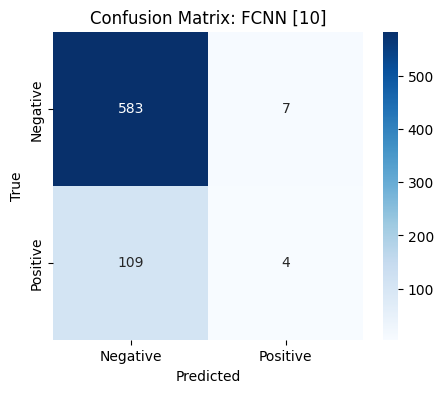


===== Training Neural Network with hidden layers: [17] =====
Accuracy : 0.5789
Recall   : 0.6726
Precision: 0.2269
F1 Score : 0.3393
Confusion Matrix:
 [[331 259]
 [ 37  76]]


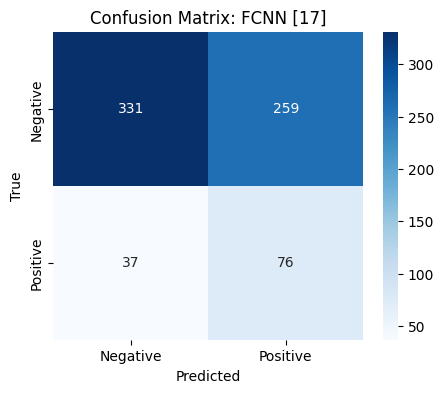


===== Training Neural Network with hidden layers: [31] =====
Accuracy : 0.7568
Recall   : 0.6195
Precision: 0.3535
F1 Score : 0.4502
Confusion Matrix:
 [[462 128]
 [ 43  70]]


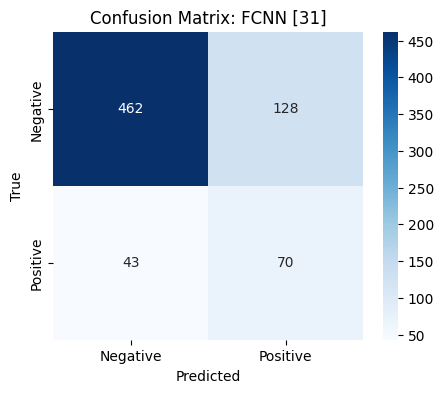


===== Training Neural Network with hidden layers: [64] =====
Accuracy : 0.7610
Recall   : 0.5664
Precision: 0.3497
F1 Score : 0.4324
Confusion Matrix:
 [[471 119]
 [ 49  64]]


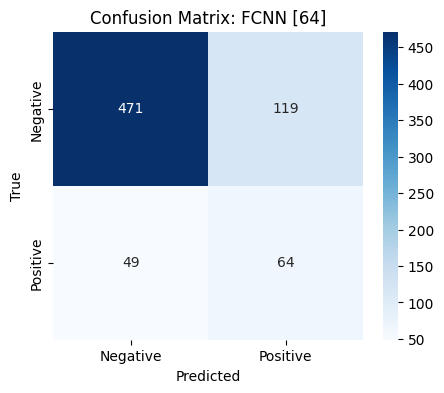


===== Training Neural Network with hidden layers: [100] =====
Accuracy : 0.7568
Recall   : 0.8230
Precision: 0.3811
F1 Score : 0.5210
Confusion Matrix:
 [[439 151]
 [ 20  93]]


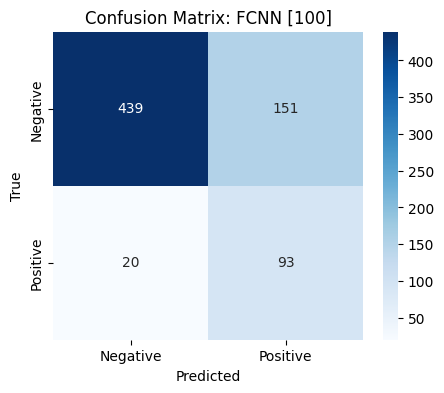


===== Training Neural Network with hidden layers: [32, 16] =====
Accuracy : 0.6785
Recall   : 0.5044
Precision: 0.2511
F1 Score : 0.3353
Confusion Matrix:
 [[420 170]
 [ 56  57]]


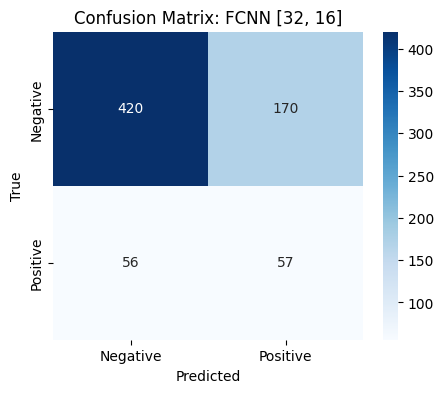


===== Training Neural Network with hidden layers: [64, 32, 16] =====
Accuracy : 0.8393
Recall   : 0.0000
Precision: 0.0000
F1 Score : 0.0000
Confusion Matrix:
 [[590   0]
 [113   0]]


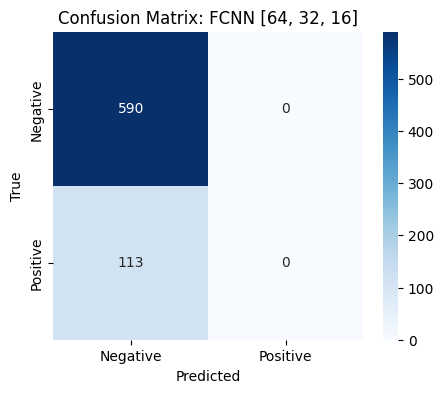


========= Best Neural Net Results =========
Best Accuracy from: [64, 32, 16]
Best Recall from: [100]
Best Precision from: [100]
Best F1-score from: [100]


In [220]:
hidden_layer_configs = [[10], [17], [31], [64], [100], [32, 16], [64, 32, 16]]

model, y_valid_true, y_test_true, y_valid_pred, y_test_pred = train_model_fcnn(
    df_train, df_valid, df_test,
    target_column="Hazardous",
    num_epochs=1000,
    lr=0.001,
    hidden_layers_list=hidden_layer_configs,
    seed=42
)


In [223]:
#tuning different knn values
df_train_full_knn, df_temp_knn = train_test_split(df_knn, test_size=0.3, random_state=42, stratify=df_knn['Hazardous'])
df_valid_knn, df_test_knn = train_test_split(df_temp_knn, test_size=0.5, random_state=42, stratify=df_temp_knn['Hazardous'])

In [224]:
df_train_knn, df_valid_knn, df_test_knn = remove_outliers_zscore(df_train_full_knn, df_valid_knn, df_test_knn)

In [226]:
df_train_knn, df_valid_knn, df_test_knn = label_encode_categorical(df_train_knn, df_valid_knn, df_test_knn)

In [227]:
df_train_knn, df_valid_knn, df_test_knn = standardize_data(df_train_knn, df_valid_knn, df_test_knn)

In [228]:
def mahalanobis_distance(x, mean, inv_cov_matrix):
    diff = x - mean
    mahal_dist = np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))
    return mahal_dist

In [229]:
def knn_mahalanobis(X_train, y_train, X_test, K):
    # mean_vector = np.mean(X_train, axis=0)  # Compute mean of training data
    cov_matrix = np.cov(X_train.T)
    inv_cov_matrix = np.linalg.pinv(cov_matrix)  # Compute pseudo-inverse for stability
    y_pred = []

    for x in X_test:
        distances = [mahalanobis_distance(x, X_train[i], inv_cov_matrix) for i in range(len(X_train))]
        k_nearest_indices = np.argsort(distances)[:K]
        k_nearest_labels = y_train[k_nearest_indices]
        most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]
        y_pred.append(most_common_label)

    return np.array(y_pred)

In [233]:
def train_model_knn(df_train, df_valid, df_test, target_column="Hazardous", k_values = [1, 3, 5, 7, 11,13,17,19,23,29,31]):

  X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)

  X_train_knn = np.array(X_train)
  X_valid_knn = np.array(X_valid)
  X_test_knn = np.array(X_test)

  y_train_knn = np.array(y_train)
  y_valid_knn = np.array(y_valid)
  y_test_knn = np.array(y_test)

  accuracies = []
  for k in k_values:
    y_valid_pred = knn_mahalanobis(X_train_knn, y_train_knn, X_valid_knn, k)
    acc = accuracy_score(y_valid_knn, y_valid_pred)
    accuracies.append(acc)

  # Find the best K
  best_k = k_values[np.argmax(accuracies)]

  mean_vector = np.mean(X_train_knn, axis=0)
  cov_matrix = np.cov(X_train_knn.T)
  inv_cov_matrix = np.linalg.pinv(cov_matrix)
  knn_final = KNeighborsClassifier(n_neighbors=best_k, metric="mahalanobis", metric_params={"VI": inv_cov_matrix})
  knn_final.fit(X_train_knn, y_train_knn)

  y_valid_pred_knn = knn_final.predict(X_valid_knn)
  y_test_pred_knn = knn_final.predict(X_test_knn)

  return knn_final, y_valid_knn, y_test_knn, y_valid_pred_knn, y_test_pred_knn


Evaluation Metrics for KNN with Mahalanobis (Validation):


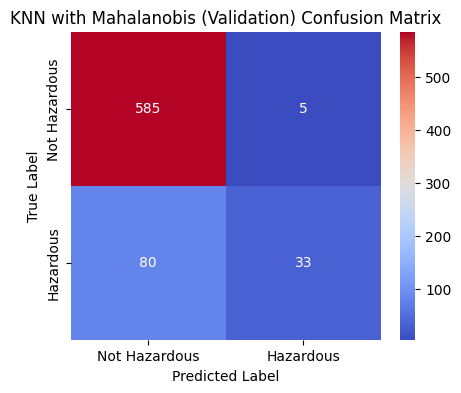


=== Evaluation Report for KNN with Mahalanobis (Validation) ===
Accuracy : 0.8791
Recall   : 0.2920
Precision: 0.8684
F1 Score : 0.4371

Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.99      0.93       590
        True       0.87      0.29      0.44       113

    accuracy                           0.88       703
   macro avg       0.87      0.64      0.68       703
weighted avg       0.88      0.88      0.85       703


Evaluation Metrics for KNN with Mahalanobis (Test):


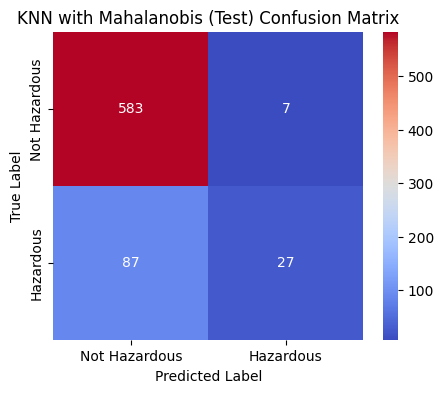


=== Evaluation Report for KNN with Mahalanobis (Test) ===
Accuracy : 0.8665
Recall   : 0.2368
Precision: 0.7941
F1 Score : 0.3649

Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.99      0.93       590
        True       0.79      0.24      0.36       114

    accuracy                           0.87       704
   macro avg       0.83      0.61      0.65       704
weighted avg       0.86      0.87      0.83       704



In [234]:
_, y_valid_knn, y_test_knn, y_valid_pred_knn, y_test_pred_knn = train_model_knn(df_train_knn, df_valid_knn, df_test_knn)
evaluate_model(y_valid_knn, y_valid_pred_knn, "KNN with Mahalanobis (Validation)")
evaluate_model(y_test_knn, y_test_pred_knn, "KNN with Mahalanobis (Test)")

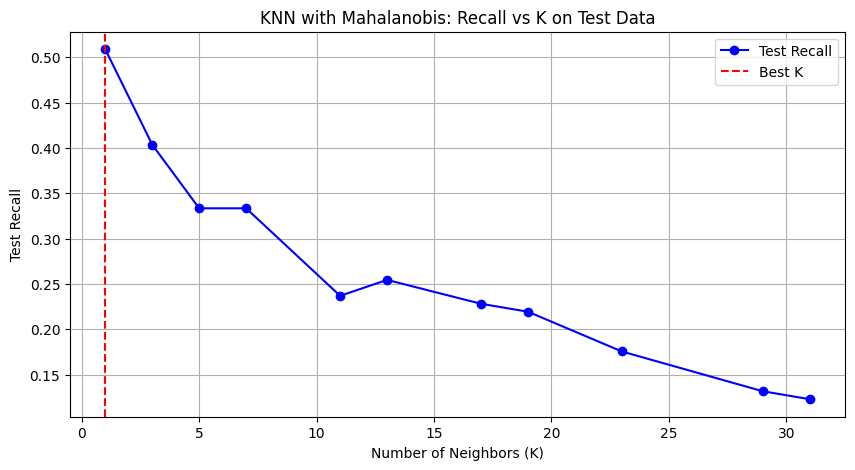

In [232]:
from sklearn.metrics import recall_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Prepare data
X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)

X_train_knn = np.array(X_train)
X_valid_knn = np.array(X_valid)
X_test_knn = np.array(X_test)

y_train_knn = np.array(y_train)
y_valid_knn = np.array(y_valid)
y_test_knn = np.array(y_test)

recalls = []
k_values = [1, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31]

# Calculate recall for different values of k on test data
for k in k_values:
    y_test_pred = knn_mahalanobis(X_train_knn, y_train_knn, X_test_knn, k)
    recall = recall_score(y_test_knn, y_test_pred, zero_division=0)
    recalls.append(recall)

# Find the best K
best_k = k_values[np.argmax(recalls)]

# Train the final model with the best K value on the entire training set
mean_vector = np.mean(X_train_knn, axis=0)
cov_matrix = np.cov(X_train_knn.T)
inv_cov_matrix = np.linalg.pinv(cov_matrix)
knn_final = KNeighborsClassifier(n_neighbors=best_k, metric="mahalanobis", metric_params={"VI": inv_cov_matrix})
knn_final.fit(X_train_knn, y_train_knn)

# Plot Recall vs K on test data
plt.figure(figsize=(10, 5))
plt.plot(k_values, recalls, marker='o', linestyle='-', color='blue', label="Test Recall")
plt.axvline(x=best_k, color='red', linestyle='--', label="Best K")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Test Recall")
plt.title("KNN with Mahalanobis: Recall vs K on Test Data")
plt.legend()
plt.grid()
plt.show()
